## Create a Panoptic Model
If I'm not mistaken when creating a panoptic model i need to change how the info is provided for the metadata catalog.
|               Task              |               Fields               |
|:-------------------------------:|:----------------------------------:|
| Common                          | file_name, height, width, image_id |
| Instance detection/segmentation | annotations                        |
| Semantic segmentation           | sem_seg_file_name                  |
| Panoptic segmentation           | pan_seg_file_name, segments_info   |

Source: https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset

So now I need to change how my methods load the metadata and provide the common fields and the panoptic ones.

Thing vs Stuff source: https://openaccess.thecvf.com/content_cvpr_2018/papers/Caesar_COCO-Stuff_Thing_and_CVPR_2018_paper.pdf


In [1]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np

import os, cv2, random

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

"Image" folders contain GF-2 images, "Annotation" folders contain label masks, and "Coordinate" folder provides the corresponding coordinate files.

Image_16bit_BGRNir: 150 raw 16-bit GF-2 images, of which the band order is B, G, R, Nir.
Image__8bit_NirRGB: 150 re-quantized 8-bit GF-2 images, of which the band order is Nir, R, G, B.

Annotation__color: 150 colorful label masks, with colors representing different categories.
Annotation__index: 150 single-channel label masks, with pixel values representing class indexes.

Different re-quantization methods have an impact on the performance of domain adaptation, so we provide both raw and processed (used in our article) images. 

Raw 16-bit images can be used more flexibly for a variety of potential applications. 

For 8-bit images, we change the band order to make it easier to annotate. The annotation information of color label and index label are the same. 

The colorful label masks can be used for visual observation, and the indexed label masks can be used directly for training.

#### Correspondence of colors (RGB) and categories:
* 200,   0,   0: industrial area
*   0, 200,   0: paddy field
* 150, 250,   0: irrigated field
* 150, 200, 150: dry cropland
* 200,   0, 200: garden land
* 150,   0, 250: arbor forest
* 150, 150, 250: shrub forest
* 200, 150, 200: park
* 250, 200,   0: natural meadow
* 200, 200,   0: artificial meadow
*   0,   0, 200: river
* 250,   0, 150: urban residential
*   0, 150, 200: lake
*   0, 200, 250: pond
* 150, 200, 250: fish pond
* 250, 250, 250: snow
* 200, 200, 200: bareland
* 200, 150, 150: rural residential
* 250, 200, 150: stadium
* 150, 150,   0: square
* 250, 150, 150: road
* 250, 150,   0: overpass
* 250, 200, 250: railway station
* 200, 150,   0: airport
*   0,   0,   0: unlabeled

#### Correspondence of indexes and categories:
*  1: industrial area
*  2: paddy field
*  3: irrigated field
*  4: dry cropland
*  5: garden land
*  6: arbor forest
*  7: shrub forest
*  8: park
*  9: natural meadow
* 10: artificial meadow
* 11: river
* 12: urban residential
* 13: lake
* 14: pond
* 15: fish pond
* 16: snow
* 17: bareland
* 18: rural residential
* 19: stadium
* 20: square
* 21: road
* 22: overpass
* 23: railway station
* 24: airport
*  0: unlabeled


To train: 
* python train_net_gaofen_panoptic_all_classes.py --num-gpus 1 --config-file /home/pablo.canosa/wip/Mask2Former/configs/gaofen/panoptic-segmentation/maskformer2_R50_bs16_50ep.yaml



Diccionarios escogidos a mano

thing_classes  = [
    "industrial area",
    "paddy field",
    "irrigated field",
    "garden land",
    "park",
    "urban residential",
    "pond",
    "fish pond",
    "rural residential",
    "stadium",
    "square",
    "overpass",
    "railway station",
    "airport"
]

stuff_classes = [ # Entiendo por stuff las cosas que no puedo contar
    "unlabeled",
    "dry cropland",
    "garden land",
    "arbor forest",
    "shrub forest",
    "natural meadow",
    "artificial meadow",
    "river",
    "lake",
    "snow",
    "bareland",
    "road"
    ]

thing_dataset_id_to_contiguous_id = {
    0:1,
    1:2,
    2:3,
    3:5,
    4:8,
    5:12,
    6:14,
    7:15,
    8:18,
    9:19,
    10:20,
    11:22,
    12:23,
    13:24
}

thing_dataset_id_to_contiguous_id_inverted_dict = {
    1: 0,
    2: 1,
    3: 2,
    5: 3,
    8: 4,
    12: 5,
    14: 6,
    15: 7,
    18: 8,
    19: 9,
    20: 10,
    22: 11,
    23: 12,
    24: 13
}

stuff_dataset_id_to_contiguous_id = {
    0:0,
    1:4,
    2:5,
    3:6,
    4:7,
    5:9,
    6:10,
    7:11,
    8:13,
    9:16,
    10:17,
    11:21
}

stuff_dataset_id_to_contiguous_id_inverted_dict = {
    0: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    9: 5,
    10: 6,
    11: 7,
    13: 8,
    16: 9,
    17: 10,
    21: 11
}


* ESTA ES LA SALIDA SIN EL CONTIGUOUS

| Task    | mIoU  | fwIoU | mACC  | pACC  |
|---------|-------|-------|-------|-------|
| sem_seg | 0.2348 | 0.2667 | 4.5455 | 5.1646 |

Aquí se puede ver como emplea todas las clases

| Class                | IoU  | BoundaryIoU  | min(IoU, B-IoU)  | ACC    |
|----------------------|------|--------------|------------------|--------|
| unlabeled            | nan  | 44.5077      | nan              | nan    |
| industrial area      | 0.0  | 0.0          | 0.0              | 0.0    |
| paddy field          | 0.0  | 0.0372       | 0.0              | 0.0    |
| irrigated field      | 0.0  | 0.0          | 0.0              | 0.0    |
| dry cropland         | 0.0  | 0.0          | 0.0              | 0.0    |
| garden land          | 0.0  | 0.0          | 0.0              | 0.0    |
| arbor forest         | 0.0  | 0.0          | 0.0              | 0.0    |
| shrub forest         | 0.0  | 0.0          | 0.0              | 0.0    |
| park                 | 0.0  | 0.0          | 0.0              | 0.0    |
| natural meadow       | 0.0  | 0.0          | 0.0              | 0.0    |
| artificial meadow    | 0.0  | 0.0          | 0.0              | 0.0    |
| river                | 0.0  | 0.0          | 0.0              | 0.0    |
| urban residential    | 0.0  | 0.0          | 0.0              | 0.0    |
| lake                 | 0.0  | 0.0          | 0.0              | 0.0    |
| pond                 | 0.0  | 0.0          | 0.0              | 0.0    |
| fish pond            | 0.0  | 0.0          | 0.0              | 0.0    |
| snow                 | nan  | 0.0          | nan              | nan    |
| bareland             | 0.0  | 0.0          | 0.0              | 0.0    |
| rural residential    | 0.0  | 0.0          | 0.0              | 0.0    |
| stadium              | 0.0  | 0.0          | 0.0              | 0.0    |
| square               | 0.0  | 0.0          | 0.0              | 0.0    |
| road                 | 5.1646| 0.0         | 0.0              | 100.0  |
| overpass             | 0.0  | 0.0          | 0.0              | 0.0    |
| railway station      | 0.0  | 0.0          | 0.0              | 0.0    |
| airport              | nan  | 0.0          | nan              | nan    |

Summary metrics:
- **mIoU:** 0.2348
- **fwIoU:** 0.2667
- **mACC:** 4.5455
- **pACC:** 5.1646

* ESTA ES LA SALIDA CON EL CONTIGUOUS

| Task    | mIoU  | fwIoU | mACC  | pACC  |
|---------|-------|-------|-------|-------|
| sem_seg | 0.1323 | 0.1774 | 0.6122 | 0.8207 |

No entiendo porque solo usa una clase

| Class               | IoU   | BoundaryIoU | min(IoU, B-IoU) | ACC    |
|---------------------|-------|-------------|-----------------|--------|
| unlabeled           | 0.0   | 44.0132     | 0.0             | 0.0    |
| dry cropland        | 1.5878| 1.2255      | 1.2255          | 7.3467 |
| garden land         | 0.0   | 0.0         | 0.0             | 0.0    |
| arbor forest        | 0.0   | 0.0         | 0.0             | 0.0    |
| shrub forest        | 0.0   | 0.0         | 0.0             | 0.0    |
| natural meadow      | 0.0   | 0.0         | 0.0             | 0.0    |
| artificial meadow   | 0.0   | 0.0         | 0.0             | 0.0    |
| river               | 0.0   | 0.0         | 0.0             | 0.0    |
| lake                | 0.0   | 0.0         | 0.0             | 0.0    |
| snow                | 0.0   | 0.0         | 0.0             | 0.0    |
| bareland            | 0.0   | 0.0         | 0.0             | 0.0    |
| road                | 0.0   | 0.0         | 0.0             | 0.0    |

Summary metrics:
- **mIoU:** 0.1323
- **fwIoU:** 0.1774
- **mACC:** 0.6122
- **pACC:** 0.8207


### Yo creo que el problema puede ser causado por el tipo de evaluator que se emplea, en este caso es sem_seg, porque entiendo que no está hecho para funcionar con segmentación panóptica

Conseguí poner a funcionar una vez la demo y me da que solo marca carretera alomejor es que tengo que hacer una prueba entrenando más rato

*  python demo_gaofen_panoptic.py --config-file /home/pablo.canosa/wip/Mask2Former/output/config.yaml --input /home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0001389317-MSS2_2.tif --opts  MODEL.WEIGHTS /home/pablo.canosa/wip/Mask2Former/output/model_final.pth

*  python train_net_gaofen_panoptic.py --num-gpus 1 --config-file /home/pablo.canosa/wip/Mask2Former/configs/gaofen/panoptic-segmentation/maskformer2_R50_bs16_50ep.yaml

* python demo_gaofen_panoptic.py --config-file /home/pablo.canosa/wip/datasets/small_gaofen/last_checkpoint/semantic_segmentation_working/output/config.yaml --input /home/pablo.canosa/wip/datasets/small_gaofen/test/test_8bit_images/GF2_PMS1__L1A0001064454-MSS1_1.tif --opts  MODEL.WEIGHTS /home/pablo.canosa/wip/datasets/small_gaofen/last_checkpoint/semantic_segmentation_working/output/model_final.pth 

This is to execute the demo from the new models_and_results folder:

* python demo_gaofen_panoptic.py --config-file /home/pablo.canosa/wip/models_and_results/semantic_segmentation_working/output/config.yaml --input /home/pablo.canosa/wip/datasets/small_gaofen/test/test_8bit_images/GF2_PMS1__L1A0001064454-MSS1_1.tif --opts  MODEL.WEIGHTS /home/pablo.canosa/wip/models_and_results/semantic_segmentation_working/output/model_final.pth 

Full sized images

* python demo_mod_full_size.py --config-file /home/pablo.canosa/wip/models_and_results/semantic_segmentation_full_size_RGBA/output/config.yaml --input /home/pablo.canosa/wip/datasets/split_gaofen/test_8bit/GF2_PMS1__L1A0001064454-MSS1.tif --opts MODEL.WEIGHTS /home/pablo.canosa/wip/models_and_results/semantic_segmentation_full_size_RGBA/output/model_final.pth 


### First seemingly correct results obtained

This are the last metrics I was able to get, the total training time was 1 hour 40 minutes, 5000 epochs(this took 30 minutes while testing took 70 minutes). As far as I understand it seem that it gives good enough results.

| Metric | Value |
| --- | --- |
| mIoU | 45.9632 |
| fwIoU | 70.6688 |
| mACC | 56.2398 |
| pACC | 82.2768 |

Detailed Evaluation Results:

| Category | IoU | BoundaryIoU | min(IoU, B-Iou) | ACC |
| --- | --- | --- | --- | --- |
| unlabeled | nan | 52.1641 | nan | nan |
| industrial area | 54.3546 | 11.0429 | 11.0429 | 61.8217 |
| paddy field | 61.8353 | 14.4552 | 14.4552 | 71.0674 |
| irrigated field | 81.8356 | 30.6796 | 30.6796 | 96.0505 |
| dry cropland | 49.9484 | 5.2827 | 5.2827 | 55.3113 |
| garden land | 18.5629 | 4.6788 | 4.6788 | 24.6766 |
| arbor forest | 87.8908 | 15.4876 | 15.4876 | 90.0125 |
| shrub forest | 15.2944 | 2.9790 | 2.9790 | 41.5332 |
| park | 22.5147 | 11.5777 | 11.5777 | 42.3210 |
| natural meadow | 57.3488 | 9.3348 | 9.3348 | 65.3022 |
| artificial meadow | 20.2902 | 0.0 | 0.0 | 24.6444 |
| river | 75.3106 | 0.0 | 0.0 | 80.3407 |
| urban residential | 66.8068 | 0.0 | 0.0 | 85.0932 |
| lake | 83.9852 | 0.0 | 0.0 | 96.2232 |
| pond | 17.1817 | 0.0 | 0.0 | 19.9229 |
| fish pond | 56.0507 | 0.0 | 0.0 | 64.1956 |
| snow | 21.8494 | 0.0 | 0.0 | 44.2992 |
| bareland | 51.5312 | 0.0 | 0.0 | 62.3732 |
| rural residential | 54.6258 | 0.0 | 0.0 | 80.3929 |
| stadium | 32.3711 | 0.0 | 0.0 | 35.0483 |
| square | 0.0 | 0.0 | 0.0 | 0.0 |
| road | 45.5503 | 0.0 | 0.0 | 58.2836 |
| overpass | 48.2149 | 0.0 | 0.0 | 63.2185 |
| railway station | 30.2198 | 0.0 | 0.0 | 36.4348 |
| airport | 49.5428 | 0.0 | 0.0 | 51.1878 |

### Papers that contain Gaofen/FiveBillionPixels metrics

Paper 1: https://openaccess.thecvf.com/content/ICCV2023/papers/Dong_Large-Scale_Land_Cover_Mapping_with_Fine-Grained_Classes_via_Class-Aware_Semi-Supervised_ICCV_2023_paper.pdf

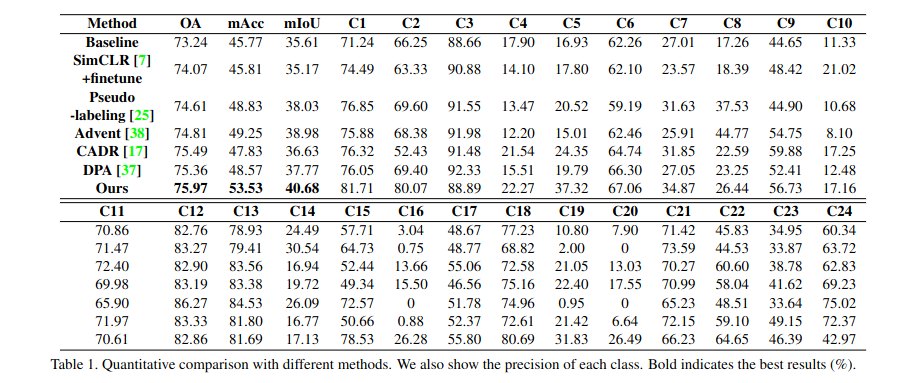


Paper 2: https://arxiv.org/pdf/2312.10114v2

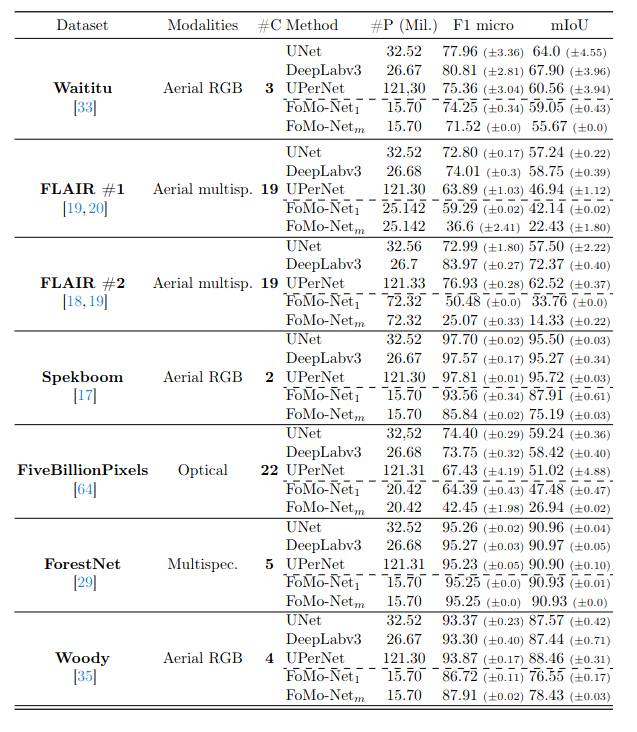

Paper 3: https://arxiv.org/pdf/2209.00727v2

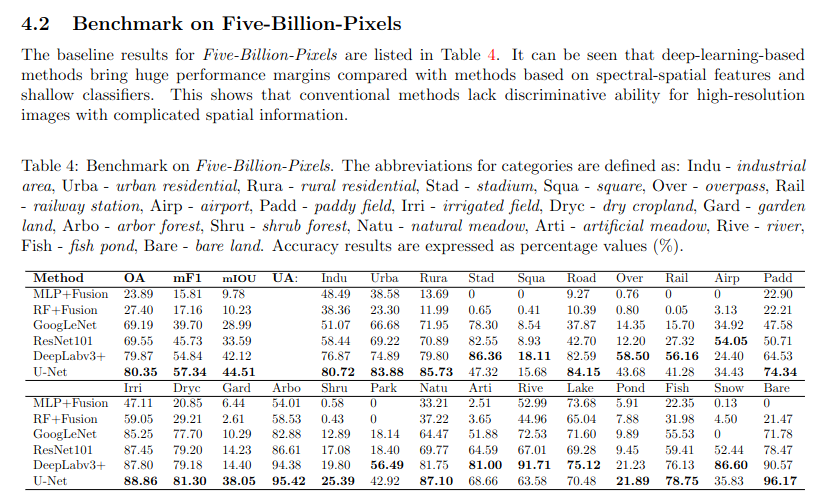


| Method                | OA    | mAcc  | mIoU |
|-----------------------|-------|-------|------|
| Baseline              | 73.24 | 45.77 | 35.61|
| SimCLR + finetune     | 74.07 | 45.81 | 35.17|
| Pseudo-labeling       | 74.61 | 48.83 | 38.03|
| Advent                | 74.81 | 49.25 | 38.98|
| CADR                  | 75.49 | 47.83 | 36.63|
| DPA                   | 75.36 | 48.57 | 37.77|
| CASSSS-SemSegApproach | 75.97 | 53.53 | 40.68|
|-----------------------|-------|-------|------|
| UNet                  |       |       | 59.24|
| DeepLabv3             |       |       | 58.42|
| UPerNet               |       |       | 51.02|
| FoMo-Net1             |       |       | 47.48|
| FoMo-Netm             |       |       | 26.94|
|-----------------------|-------|-------|------|
| MLP+Fusion            | 23.89 |       | 9.78 |
| RF+Fusion             | 27.40 |       | 10.23|
| GoogLeNet             | 69.19 |       | 28.99|
| ResNet101             | 69.55 |       | 33.59|
| DeepLabv3+            | 79.87 |       | 42.12|
| U-Net                 | 80.35 |       | 44.51|

sources for the metrics :

p1: https://openaccess.thecvf.com/content/ICCV2023/papers/Dong_Large-Scale_Land_Cover_Mapping_with_Fine-Grained_Classes_via_Class-Aware_Semi-Supervised_ICCV_2023_paper.pdf

p2: https://arxiv.org/pdf/2312.10114v2

p3: https://arxiv.org/pdf/2209.00727v2

## All classes

In [2]:
# This are the paths for the dataset files in quadrants
dataset_path_image = '/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/' 
dataset_path_png_mask = '/home/pablo.canosa/wip/datasets/small_gaofen/train/png_masks/'
dataset_path_tif_mask = '/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/'

In [7]:
ID_TO_COLOR_DICT = {    
    0: (0, 0, 0),
    1: (200, 0, 0),
    2: (0, 200, 0),
    3: (150, 250, 0),
    4: (150, 200, 150),
    5: (200, 0, 200),
    6: (150, 0, 250),
    7: (150, 150, 250),
    8: (200, 150, 200),
    9: (250, 200, 0),
    10: (200, 200, 0),
    11: (0, 0, 200),
    12: (250, 0, 150),
    13: (0, 150, 200),
    14: (0, 200, 250),
    15: (150, 200, 250),
    16: (250, 250, 250),
    17: (200, 200, 200),
    18: (200, 150, 150),
    19: (250, 200, 150),
    20: (150, 150, 0),
    21: (250, 150, 150),
    22: (250, 150, 0),
    23: (250, 200, 250),
    24: (200, 150, 0)
}

def get_gaofen_dict(images_path, gt_dir_png, gt_dir_tif_color):
    
    dataset_dicts = []
    number_of_images = len(os.listdir(images_path))
    for image_idx, image_filename in enumerate(os.listdir(images_path)):

        print(f"{image_filename} is image {image_idx+1} out of {number_of_images}")
        record={}

        image_file_path = os.path.join(images_path, image_filename)  # Get the full path of the file


        image_id = image_filename[:-4]# eliminar el .tif para tener el image_id 
                                    # (str or int): a unique id that identifies this image. 
                                    #Required by many evaluators to identify the images, but a dataset may use it for different purposes.


        height, width = cv2.imread(image_file_path, cv2.IMREAD_UNCHANGED).shape[:2]

        record["file_name"] = image_file_path
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width

        # Path a la mascara de segmentacion semantica en escala de grises
        gt_mask_grayscale = os.path.join(gt_dir_png, image_id + '_24label.png')
        record["sem_seg_file_name"] = gt_mask_grayscale

        # ahora hay que proporcionar la direccion a los gt de segmentacion panoptica en color
        pan_seg_file_name = os.path.join(gt_dir_tif_color, image_id + '_24label.tif')

        record["pan_seg_file_name"] = pan_seg_file_name
        
        # Proporcionar la info de los segmentos list[dict] 
        # segments_info (list[dict]): defines the meaning of each id in panoptic segmentation ground truth. Each dict has the following keys:
            # id (int): integer that appears in the ground truth image.
            # category_id (int): an integer in the range [0, num_categories-1] representing the category label.
            # iscrowd: 0 (default) or 1. Whether this instance is labeled as COCO’s “crowd region”.
        

        segments_info = []
        # if the gt_mask_grayscale contains the id of the class, then add it to the segments_info
        gt_mask_grayscale = cv2.imread(gt_mask_grayscale, cv2.IMREAD_UNCHANGED)
        for i in ID_TO_COLOR_DICT.keys():
            if np.any(gt_mask_grayscale == i):
                segments_info.append({'id': ID_TO_COLOR_DICT[i], 'category_id': i, 'iscrowd': 0})

              
        record["segments_info"] = segments_info
        print(len(segments_info))

        #End loop and save dict
        dataset_dicts.append(record)
        #### ESTO ES UNA COSA CUTRE PARA PODER HACER PRUEBAS y que para cuando tenga cargadas n imagenes en el formato compatible con detectron
        if(len(dataset_dicts) == 25):
            break

    return dataset_dicts

In [4]:
DatasetCatalog.register("gaofen_panoptic", lambda : get_gaofen_dict(dataset_path_image,dataset_path_png_mask,dataset_path_tif_mask))

In [5]:
MetadataCatalog.get("gaofen_panoptic").thing_classes  = [
    "unlabeled",
    "industrial area",
    "paddy field",
    "irrigated field",
    "dry cropland",
    "garden land",
    "arbor forest",
    "shrub forest",
    "park",
    "natural meadow",
    "artificial meadow",
    "river",
    "urban residential",
    "lake",
    "pond",
    "fish pond",
    "snow",
    "bareland",
    "rural residential",
    "stadium",
    "square",
    "road",
    "overpass",
    "railway station",
    "airport"
]# Creo que por tal y como hago todo esto deberia estar vacio ya que todo lo que uso yo es stuff
MetadataCatalog.get("gaofen_panoptic").ignore_label = [0] # esto es para que ignore los ids con ese valor
MetadataCatalog.get("gaofen_panoptic").stuff_classes = [ # Entiendo por stuff las cosas que no puedo contar
    "unlabeled",
    "industrial area",
    "paddy field",
    "irrigated field",
    "dry cropland",
    "garden land",
    "arbor forest",
    "shrub forest",
    "park",
    "natural meadow",
    "artificial meadow",
    "river",
    "urban residential",
    "lake",
    "pond",
    "fish pond",
    "snow",
    "bareland",
    "rural residential",
    "stadium",
    "square",
    "road",
    "overpass",
    "railway station",
    "airport" 
    ]
gaofen_metadata = MetadataCatalog.get("gaofen_panoptic")

In [6]:
dataset_dicts = get_gaofen_dict(dataset_path_image,dataset_path_png_mask,dataset_path_tif_mask)


GF2_PMS2__L1A0001389317-MSS2_2.tif is image 1 out of 480
15
GF2_PMS2__L1A0001708259-MSS2_2.tif is image 2 out of 480
12
GF2_PMS1__L1A0001668483-MSS1_0.tif is image 3 out of 480
7
GF2_PMS2__L1A0000948183-MSS2_1.tif is image 4 out of 480
11
GF2_PMS2__L1A0001573999-MSS2_0.tif is image 5 out of 480
6
GF2_PMS2__L1A0001787089-MSS2_2.tif is image 6 out of 480
7
GF2_PMS1__L1A0000564539-MSS1_0.tif is image 7 out of 480
16
GF2_PMS1__L1A0001765570-MSS1_0.tif is image 8 out of 480
10
GF2_PMS1__L1A0001821711-MSS1_1.tif is image 9 out of 480
10
GF2_PMS2__L1A0001799009-MSS2_0.tif is image 10 out of 480
16
GF2_PMS2__L1A0001167480-MSS2_3.tif is image 11 out of 480
6
GF2_PMS2__L1A0001537636-MSS2_3.tif is image 12 out of 480
14
GF2_PMS1__L1A0001553848-MSS1_1.tif is image 13 out of 480
14
GF2_PMS2__L1A0001824765-MSS2_1.tif is image 14 out of 480
9
GF2_PMS2__L1A0001140983-MSS2_3.tif is image 15 out of 480
10
GF2_PMS2__L1A0001092725-MSS2_1.tif is image 16 out of 480
19
GF2_PMS1__L1A0001112719-MSS1_0.tif is 

In [7]:
# mostrar imagenes de crops para ver si se cargan bien

# This code snippet is taken from the dectectron colab tutorial on how to load custom datasets. It is used to check if the dictionary with the metadata was correctly created.
for idx ,d in enumerate(random.sample(dataset_dicts, 3)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=gaofen_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow("Prueba",out.get_image()[:, :, ::-1])
    cv2.waitKey(0) 
    # closing all open windows 
    cv2.destroyAllWindows() 
    #cv2.imwrite(f"samples/prueba_{idx}.png", out.get_image()[:, :, ::-1])

/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/GF2_PMS1__L1A0001767953-MSS1_1.tif
/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0001433318-MSS2_1.tif
/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/GF2_PMS1__L1A0001821711-MSS1_1.tif


## Stuff vs thing Problems

In [3]:
# This are the paths for the dataset files in quadrants
# Estoy trabajando con las imágenes de test por curiosidad, no hay ninguna otra razón
dataset_path_image = '/home/pablo.canosa/wip/datasets/small_gaofen/test/test_8bit_images' 
dataset_path_png_mask = '/home/pablo.canosa/wip/datasets/small_gaofen/test/test_masks_png'
dataset_path_tif_mask = '/home/pablo.canosa/wip/datasets/small_gaofen/test/test_masks_tif'

In [4]:
DatasetCatalog.register("gaofen_panoptic_test", lambda : get_gaofen_dict(dataset_path_image,dataset_path_png_mask,dataset_path_tif_mask))

In [5]:
MetadataCatalog.get("gaofen_panoptic_test").thing_classes  = [
    "industrial area",
    "paddy field",
    "irrigated field",
    "garden land",
    "park",
    "urban residential",
    "pond",
    "fish pond",
    "rural residential",
    "stadium",
    "square",
    "overpass",
    "railway station",
    "airport"
]




MetadataCatalog.get("gaofen_panoptic_test").ignore_label = [0] # esto es para que ignore los ids con ese valor
MetadataCatalog.get("gaofen_panoptic_test").stuff_classes = [ # Entiendo por stuff las cosas que no puedo contar
    "unlabeled",
    "dry cropland",
    "garden land",
    "arbor forest",
    "shrub forest",
    "natural meadow",
    "artificial meadow",
    "river",
    "lake",
    "snow",
    "bareland",
    "road"
    ]



thing_dataset_id_to_contiguous_id_inverted_dict = {
    1: 0,
    2: 1,
    3: 2,
    5: 3,
    8: 4,
    12: 5,
    14: 6,
    15: 7,
    18: 8,
    19: 9,
    20: 10,
    22: 11,
    23: 12,
    24: 13
}

stuff_dataset_id_to_contiguous_id_inverted_dict = {
    0: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    9: 5,
    10: 6,
    11: 7,
    13: 8,
    16: 9,
    17: 10,
    21: 11
}


MetadataCatalog.get("gaofen_panoptic_test").thing_dataset_id_to_contiguous_id = thing_dataset_id_to_contiguous_id_inverted_dict

MetadataCatalog.get("gaofen_panoptic_test").stuff_dataset_id_to_contiguous_id = stuff_dataset_id_to_contiguous_id_inverted_dict

MetadataCatalog.get("gaofen_panoptic_test").ignore_label
gaofen_metadata = MetadataCatalog.get("gaofen_panoptic_test")

In [8]:
dataset_dicts = get_gaofen_dict(dataset_path_image,dataset_path_png_mask,dataset_path_tif_mask)


GF2_PMS1__L1A0001344822-MSS1_3.tif is image 1 out of 120
14
GF2_PMS1__L1A0001432972-MSS1_2.tif is image 2 out of 120
19
GF2_PMS2__L1A0001821754-MSS2_0.tif is image 3 out of 120
12
GF2_PMS2__L1A0001396037-MSS2_3.tif is image 4 out of 120
16
GF2_PMS2__L1A0001378501-MSS2_3.tif is image 5 out of 120
16
GF2_PMS2__L1A0001396036-MSS2_3.tif is image 6 out of 120
10
GF2_PMS2__L1A0001396037-MSS2_0.tif is image 7 out of 120
20
GF2_PMS1__L1A0001344822-MSS1_2.tif is image 8 out of 120
13
GF2_PMS2__L1A0001367840-MSS2_2.tif is image 9 out of 120
10
GF2_PMS2__L1A0001821754-MSS2_3.tif is image 10 out of 120
16
GF2_PMS1__L1A0001765574-MSS1_2.tif is image 11 out of 120
10
GF2_PMS2__L1A0001038936-MSS2_1.tif is image 12 out of 120
13
GF2_PMS2__L1A0001367840-MSS2_3.tif is image 13 out of 120
11
GF2_PMS2__L1A0000718813-MSS2_1.tif is image 14 out of 120
15
GF2_PMS1__L1A0001118839-MSS1_2.tif is image 15 out of 120
13
GF2_PMS2__L1A0001378491-MSS2_2.tif is image 16 out of 120
11
GF2_PMS1__L1A0001118839-MSS1_1.ti

/home/pablo.canosa/wip/datasets/small_gaofen/test/test_8bit_images/GF2_PMS1__L1A0001432972-MSS1_2.tif


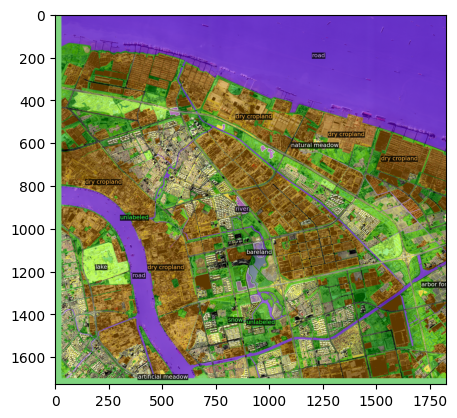

In [10]:
# mostrar imagenes de crops para ver si se cargan bien
import matplotlib.pyplot as plt
# This code snippet is taken from the detectron colab tutorial on how to load custom datasets. It is used to check if the dictionary with the metadata was correctly created.
for idx ,d in enumerate(random.sample(dataset_dicts, 1)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=gaofen_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # show images with pyplot
    plt.imshow(out.get_image()[:, :, ::-1])
    
    
    # Esto está borrado para poder hacer pruebas desde casa
    #cv2.imshow("Prueba",out.get_image()[:, :, ::-1])
    #cv2.waitKey(0) 
    # closing all open windows 
    #cv2.destroyAllWindows() 
    #cv2.imwrite(f"samples/prueba_{idx}.png", out.get_image()[:, :, ::-1])

## Load only metadata related to water
My main goal with tis is to try to fix the problem with how the labels are asigned and check if im able of working with only water.

The solution proposed doesnt work as it confuses the classes present in the masks


In [8]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

import os, cv2, random

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [9]:
# This are the paths for the dataset files in quadrants
dataset_path_image = '/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/' 
dataset_path_png_mask = '/home/pablo.canosa/wip/datasets/small_gaofen/train/png_masks/'
dataset_path_tif_mask = '/home/pablo.canosa/wip/datasets/small_gaofen/train/tif_color_masks/'

In [10]:
ID_TO_COLOR_DICT = {    
    11: (0, 0, 200),
    13: (0, 150, 200),
    14: (0, 200, 250),
    15: (150, 200, 250)
}


def get_gaofen_dict(images_path, gt_dir_png, gt_dir_tif_color):
    
    dataset_dicts = []
    number_of_images = len(os.listdir(images_path))
    for image_idx, image_filename in enumerate(os.listdir(images_path)):

        print(f"{image_filename} is image {image_idx+1} out of {number_of_images}")
        record={}

        image_file_path = os.path.join(images_path, image_filename)  # Get the full path of the file


        image_id = image_filename[:-4]# eliminar el .tif para tener el image_id 
                                    # (str or int): a unique id that identifies this image. 
                                    #Required by many evaluators to identify the images, but a dataset may use it for different purposes.


        height, width = cv2.imread(image_file_path, cv2.IMREAD_UNCHANGED).shape[:2]

        record["file_name"] = image_file_path
        record["image_id"] = image_id
        record["height"] = height
        record["width"] = width

        # Path a la mascara de segmentacion semantica en escala de grises
        gt_mask_grayscale = os.path.join(gt_dir_png, image_id + '_24label.png')
        record["sem_seg_file_name"] = gt_mask_grayscale

        # ahora hay que proporcionar la direccion a los gt de segmentacion panoptica en color
        pan_seg_file_name = os.path.join(gt_dir_tif_color, image_id + '_24label.tif')

        record["pan_seg_file_name"] = pan_seg_file_name
        
        # Proporcionar la info de los segmentos list[dict] 
        # segments_info (list[dict]): defines the meaning of each id in panoptic segmentation ground truth. Each dict has the following keys:
            # id (int): integer that appears in the ground truth image.
            # category_id (int): an integer in the range [0, num_categories-1] representing the category label.
            # iscrowd: 0 (default) or 1. Whether this instance is labeled as COCO’s “crowd region”.
        
        # Con esto teoricamente me estoy quedando solo con las partes que hacen referencia al agua
        segments_info = []
        # if the gt_mask_grayscale contains the id of the class, then add it to the segments_info
        gt_mask_grayscale = cv2.imread(gt_mask_grayscale, cv2.IMREAD_UNCHANGED)
        for i in ID_TO_COLOR_DICT.keys():
                segments_info.append({'id': ID_TO_COLOR_DICT[i], 'category_id': i, 'iscrowd' : 0})
        record["segments_info"] = segments_info
        print(len(segments_info))

        #End loop and save dict
        dataset_dicts.append(record)
        #### ESTO ES UNA COSA CUTRE PARA PODER HACER PRUEBAS y que para cuando tenga cargadas n imagenes en el formato compatible con detectron
        if(len(dataset_dicts) == 25):
            break

    return dataset_dicts

In [11]:
DatasetCatalog.register("gaofen_water", lambda : get_gaofen_dict(dataset_path_image,dataset_path_png_mask,dataset_path_tif_mask))

In [12]:
MetadataCatalog.get("gaofen_water").thing_classes  = [
    "river",
    "lake",
    "pond",
    "fish pond"
]



MetadataCatalog.get("gaofen_water").stuff_classes = [ # Entiendo por sttuf las cosas que no puedo contar
    "river",
    "lake",
    "pond",
    "fish pond"
    ]
gaofen_metadata = MetadataCatalog.get("gaofen_water")

In [13]:
dataset_dicts = get_gaofen_dict(dataset_path_image,dataset_path_png_mask,dataset_path_tif_mask)


GF2_PMS2__L1A0001389317-MSS2_2.tif is image 1 out of 480


4
GF2_PMS2__L1A0001708259-MSS2_2.tif is image 2 out of 480
4
GF2_PMS1__L1A0001668483-MSS1_0.tif is image 3 out of 480
4
GF2_PMS2__L1A0000948183-MSS2_1.tif is image 4 out of 480
4
GF2_PMS2__L1A0001573999-MSS2_0.tif is image 5 out of 480
4
GF2_PMS2__L1A0001787089-MSS2_2.tif is image 6 out of 480
4
GF2_PMS1__L1A0000564539-MSS1_0.tif is image 7 out of 480
4
GF2_PMS1__L1A0001765570-MSS1_0.tif is image 8 out of 480
4
GF2_PMS1__L1A0001821711-MSS1_1.tif is image 9 out of 480
4
GF2_PMS2__L1A0001799009-MSS2_0.tif is image 10 out of 480
4
GF2_PMS2__L1A0001167480-MSS2_3.tif is image 11 out of 480
4
GF2_PMS2__L1A0001537636-MSS2_3.tif is image 12 out of 480
4
GF2_PMS1__L1A0001553848-MSS1_1.tif is image 13 out of 480
4
GF2_PMS2__L1A0001824765-MSS2_1.tif is image 14 out of 480
4
GF2_PMS2__L1A0001140983-MSS2_3.tif is image 15 out of 480
4
GF2_PMS2__L1A0001092725-MSS2_1.tif is image 16 out of 480
4
GF2_PMS1__L1A0001112719-MSS1_0.tif is image 17 out of 480
4
GF2_PMS2__L1A0001448894-MSS2_3.tif is image 18

In [17]:
# mostrar imagenes de crops para ver si se cargan bien

# This code snippet is taken from the dectectron colab tutorial on how to load custom datasets. It is used to check if the dictionary with the metadata was correctly created.
for idx ,d in enumerate(random.sample(dataset_dicts, 2)):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=gaofen_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2.imshow("Prueba",out.get_image()[:, :, ::-1])
    cv2.waitKey(0) 
    # closing all open windows 
    cv2.destroyAllWindows() 

/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/GF2_PMS1__L1A0001094941-MSS1_1.tif
/home/pablo.canosa/wip/datasets/small_gaofen/train/8bit_images/GF2_PMS2__L1A0001433318-MSS2_1.tif


## Problemas y errores encontrados en el mapper "coco_panoptic_new_baseline_dataset_mapper.py"

Esto es un fix pocho para el mapper de "coco_panoptic_new_baseline_dataset_mapper.py", hay que añadir una línea para adaptar las mask a panopticapi: (No funciona, simplemente se retras el error a otro método, que aun me resulta más complicado)

for segment_info in segments_info:
                class_id = segment_info["category_id"]
                if not segment_info["iscrowd"]:
                    classes.append(class_id)
                    # Convert RGB to ID
                    id = segment_info["id"][0] + segment_info["id"][1] * 256 + segment_info["id"][2] * 256**2# esta linea es extra para poder cargar las mascaras de panopticapi
                    masks.append(pan_seg_gt == id)


[05/21 18:09:52 d2.engine.train_loop]: Starting training from iteration 0
Shape of mask 0: (1,)
Shape of mask 1: (1,)
Shape of mask 2: (1,)
Shape of mask 3: (1,)
Shape of pan_seg_gt: (1024, 1024)
Unique values in pan_seg_gt: [       0    64150  9869000  9869050 13145600 16384150 16422550 16435200
 16435350]



Creo que el problema es causado por la siguiente linea de código ya que no se entiende con el formato de mask2former. Probé a mostrar las másara y parece que se muestra correctamente, alomejor el problema es por la configuracion de colores.

* pan_seg_gt = utils.read_image(dataset_dict.pop("pan_seg_file_name"), "RGB")

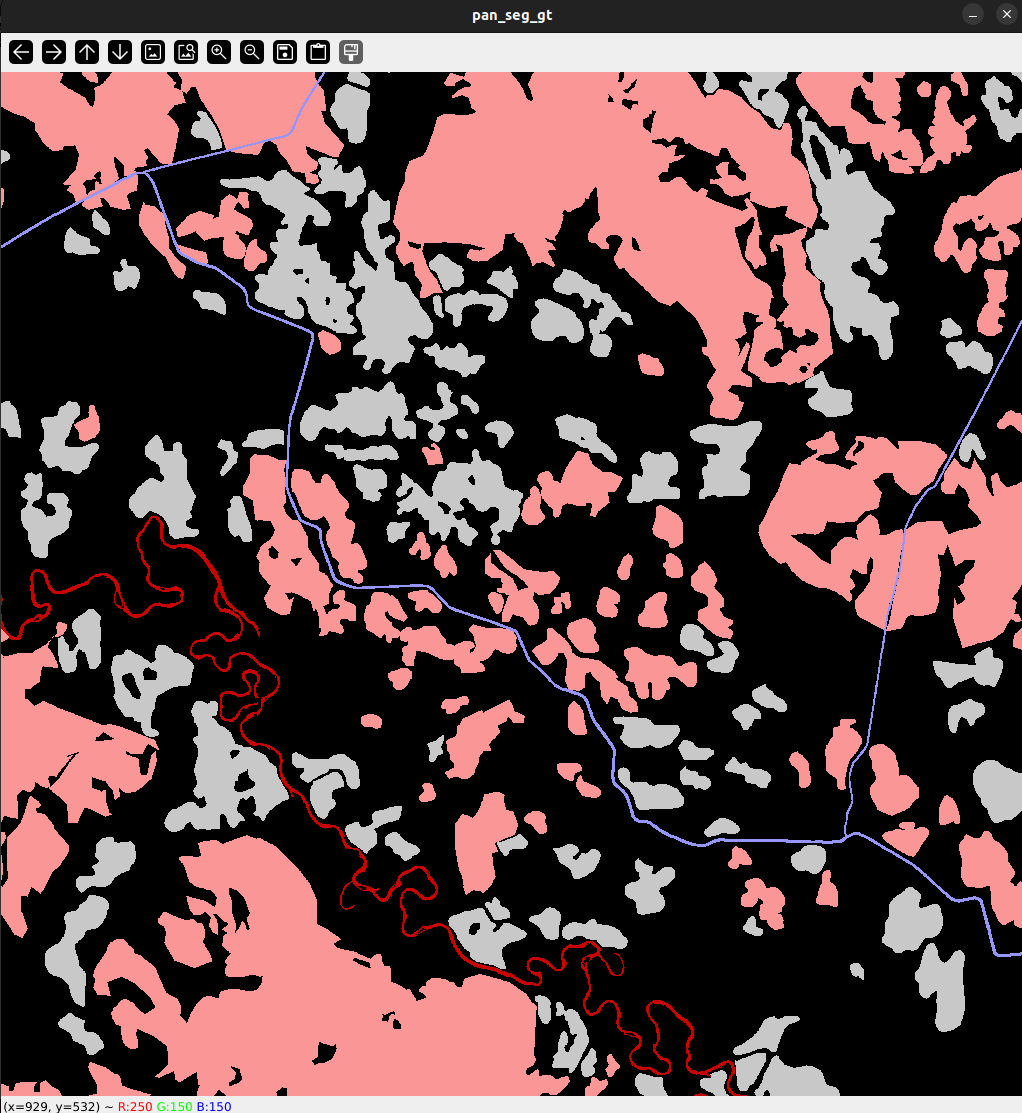

Hasta la línea 135 en la que se llama a "transforms.apply_segmentation(pan_seg_gt)" parece que funciona todo perfectamente, ya que fui comprobando los valores en cada paso y tienen sentido.

Según copilot:

The selected Python function, apply_segmentation, is a method of a class (not shown in the selection). This method is designed to apply a certain transformation to a full-image segmentation.

The method takes one argument, segmentation, which is expected to be a numpy ndarray of shape HxW (Height x Width). The dtype of the array should be either integer or boolean.

The function's purpose is to apply a transformation to the provided segmentation. However, the actual transformation is not defined in this method. Instead, it delegates this task to another method of the same class, apply_image. This is indicated by the line return self.apply_image(segmentation).

The apply_image method, as per the provided implementation details, is designed to apply a transformation to an image. It accepts an ndarray of various possible shapes and types, and returns the transformed image.

In the context of apply_segmentation, it's used to apply the same transformation to the segmentation as would be applied to an image. The transformed segmentation is then returned.

This design allows for code reusability and separation of concerns. The apply_segmentation method doesn't need to know how the transformation is done, it just needs to know that it can use apply_image to do it. This makes the code easier to maintain and understand.




Si entiendo bien el método RGBtoID coge los colores que marcan cada id y los convierte en una matrix en la que los valores de cada color son un entero unico para cada color. Una vez que crea el RGBtoID se llama a instances para inicializar una variable que contenga info de las instancias que hay en la mask. (En principio el image_shape con el que se llama al método es correcto (1024 * 1024))

El error entiendo que está más abajo...

Creo que esta en la línea 142 en el bloque:

            for segment_info in segments_info:
                class_id = segment_info["category_id"]
                if not segment_info["iscrowd"]:
                    classes.append(class_id)
                    masks.append(pan_seg_gt == segment_info["id"])

Para la versión que tengo que trabaja solo con agua da el siguiente output:

            masks [False, False, False, False]
            classes [11, 13, 14, 15]

Para la versión que trabaja con todas las clases da el siguiente output:

            masks [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
            classes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

Que en resumidas cuentas es lo mismo que para la otra, lo que me lleva a entender que es causado porque el id del color de de rgbid no coincide con el que proporciono en el segments_id o eso creo

Entiendo que lo que quiere que guarde en una matriz con False donde no hay instancia y True donde hay mask.


Es que claro nunca va a funcionar si compara lo siguiente: 

            Valores usados en la comparacion:  [[       0        0        0 ... 16777215 16777215 16777215]
            [       0        0        0 ... 16777215 16777215 16777215]
            [       0        0        0 ... 16777215 16777215 16777215]
            ...
            [16777215 16777215 16777215 ... 16777215 16777215 16777215]
            [16777215 16777215 16777215 ... 16777215 16777215 16777215]
            [16777215 16777215 16777215 ... 16777215 16777215 16777215]] (0, 0, 0)
            
El (0,0,0) es el color en origen

Ahora fui capaz de cmabiar el error y parece que las mascaras se generan bien, pero tal y como funcionan las instancias el codigo rebientas. Creo que aunque están bien generadas las mask el diccionario que proporciona el mapper esta mal hecho.


In [32]:
diccionario = {}
i = list(range(25))
for k in range(25):
        diccionario[k] = list(range(25))

print(diccionario.items())


dict_items([(0, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (1, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (2, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (4, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (5, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (7, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (8, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (9, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]), (10, [0, 1, 2, 3, 